# Centrography in `pointpats`

This notebook introduces **centrographic statistics** for planar point
patterns, focusing on:

- Measures of **central tendency** (mean center, weighted mean center,
  Manhattan and Euclidean medians)
- Measures of **dispersion and orientation** (standard distance and
  the standard deviational ellipse)
- Basic **shape descriptors** (convex hull and minimum bounding rectangle)

We will:

1. Construct a simple example point pattern and compute its centrographic
   summaries using functions from `pointpats.centrography`.
2. Visualize central tendency, dispersion, and shape diagnostics to build
   intuition about how these measures behave.
3. Explore an additional example based on simulated point patterns within the
   Virginia state border under complete spatial randomness (CSR).

This notebook is designed to live in the `docs/user-guide/` folder and be
executed automatically as part of the `pointpats` documentation build.


The python file **centrography.py** contains several functions with which we can conduct centrography analysis.
* Central Tendency
    1. mean_center: calculate the mean center of the unmarked point pattern.
    2. weighted_mean_center: calculate the weighted mean center of the marked point pattern.
    3. manhattan_median: calculate the manhattan median
    4. euclidean_median: calculate the Euclidean median
* Dispersion and Orientation
    1. std_distance: calculate the standard distance
* Shape Analysis
    1. hull: calculate the convex hull of the point pattern
    2. mbr: calculate the minimum bounding box (rectangle)
    
All of the above functions operate on a series of coordinate pairs. That is, the data type of the first argument should be $(n,2)$ array_like. In case that you have a point pattern (PointPattern instance), you need to pass its attribute "points" instead of itself to these functions.

In [1]:
import numpy as np
from pointpats import PointPattern
%matplotlib inline
import matplotlib.pyplot as plt
points = [[66.22, 32.54], [22.52, 22.39], [31.01, 81.21],
          [9.47, 31.02],  [30.78, 60.10], [75.21, 58.93],
          [79.26,  7.68], [8.23, 39.93],  [98.73, 77.17],
          [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]]
pp = PointPattern(points) #create a point pattern "pp" from list
pp.points 

,x,y
0,66.22,32.54
1,22.52,22.39
2,31.01,81.21
3,9.47,31.02
4,30.78,60.10
5,75.21,58.93
6,79.26,7.68
7,8.23,39.93
8,98.73,77.17
9,89.78,42.53


In [2]:
type(pp.points)

pandas.DataFrame

We can use PointPattern class method **plot** to visualize **pp**.

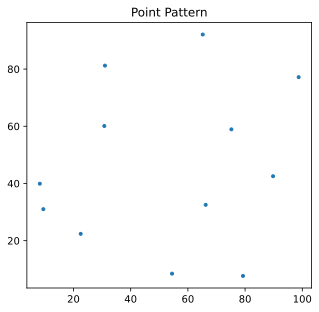

In [3]:
pp.plot()

In [4]:
#import centragraphy analysis functions 
from pointpats.centrography import hull, mean_center, minimum_bounding_rectangle, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse

## 1. Central tendency

Central Tendency concerns about the center point of the two-dimensional distribution. It is similar to the first moment of a one-dimensional distribution. There are several ways to measure central tendency, each having pros and cons. We need to carefully select the appropriate measure according to our objective and data status.

### Mean Center $(x_{mc},y_{mc})$

$$x_{mc}=\frac{1}{n} \sum^n_{i=1}x_i$$
$$y_{mc}=\frac{1}{n} \sum^n_{i=1}y_i$$

In [5]:
mc = mean_center(pp.points)
mc

array([52.57166667, 46.17166667])

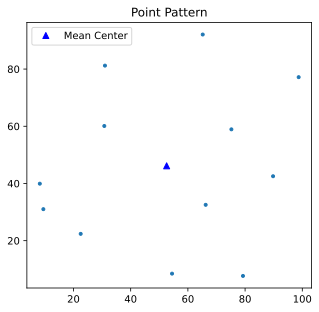

In [6]:
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend(numpoints=1)

### 1.1 Weighted mean center $(x_{wmc}, y_{wmc})$

$$x_{wmc}=\sum^n_{i=1} \frac{w_i x_i}{\sum^n_{i=1}w_i}$$
$$y_{wmc}=\sum^n_{i=1} \frac{w_i y_i}{\sum^n_{i=1}w_i}$$

Weighted mean center is meant for marked point patterns. Aside from the first argument which is a seris of $(x,y)$ coordinates in **weighted_mean_center** function, we need to specify its second argument which is the weight for each event point.

In [7]:
weights = np.arange(12)
weights

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [8]:
wmc = weighted_mean_center(pp.points, weights)
wmc

array([60.51681818, 47.76848485])

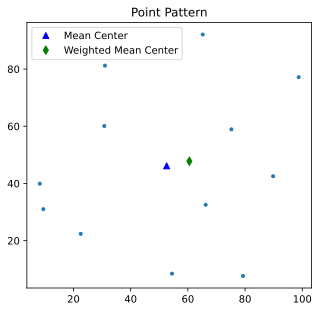

In [9]:
pp.plot() #use class method "plot" to visualize point pattern
plt.plot(mc[0], mc[1], 'b^', label='Mean Center') 
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.legend(numpoints=1)

### 1.2 Manhattan median $(x_{mm}, y_{mm})$

$$min  f(x_{mm},y_{mm})= \sum^n_{i=1}(|x_i-x_{mm}|+|y_i-y_{mm}|)$$

The Manhattan median is the location which minimizes the absolute distance to all the event points. It is an extension of the median measure in one-dimensional space to two-dimensional space. Since in one-dimensional space, a median is the number separating the higher half of a dataset from the lower half, we define the Manhattan median as a tuple whose first element is the median of $x$ coordinates and second element is the median of $y$ coordinates.

Though Manhattan median can be found very quickly, it is not unique if you have even number of points. In this case, pysal handles the Manhattan median the same way as numpy.median: return the average of the two middle values.

In [10]:
#get the number of points in point pattern "pp"
pp.n

12

In [11]:
#Manhattan Median is not unique for "pp"
mm = manhattan_median(pp.points)
mm

/home/runner/work/pointpats/pointpats/pointpats/centrography.py:505: UserWarning: Manhattan Median is not unique for even point patterns.
  return manhattan_median(points)


array([59.825, 41.23 ])

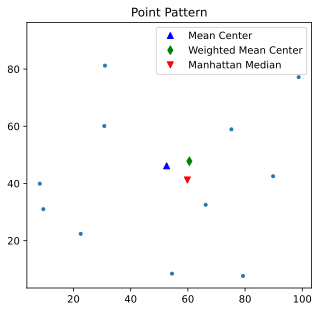

In [12]:
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.legend(numpoints=1)

### 1.3 Euclidean median $(x_{em}, y_{em})$

$$min  f(x_{em},y_{em})= \sum^n_{i=1} \sqrt{(x_i-x_{em})^2+(y_i-y_{em})^2}$$

The Euclidean Median is the location from which the sum of the Euclidean distances to all points in a distribution is a minimum. It is an optimization problem and very important for more general location allocation problems. There is no closed form solution. We can use first iterative algorithm (Kuhn and Kuenne, 1962) to approximate Euclidean Median. 

Below, we define a function named median_center with the first argument **points** a series of $(x,y)$ coordinates and the second argument **crit** the convergence criterion.

In [13]:
def median_center(points, crit=0.0001):
    points = np.asarray(points)
    x0, y0 = points.mean(axis=0)
    dx = np.inf
    dy = np.inf
    iteration = 0
    while np.abs(dx) > crit or np.abs(dy) > crit:
        xd = points[:, 0] - x0
        yd = points[:, 1] - y0
        d = np.sqrt(xd*xd + yd*yd)
        w = 1./d
        w = w / w.sum()
        x1 = w * points[:, 0]
        x1 = x1.sum()
        y1 = w * points[:, 1]
        y1 = y1.sum()
        dx = x1 - x0
        dy = y1 - y0
        iteration +=1 
        print(x0, x1, dx, dy, d.sum(), iteration)
        x0 = x1
        y0 = y1
               
    return x1, y1

In [14]:
median_center(pp.points, crit=.0001)

52.57166666666668 53.178128280602785 0.606461613936105 -0.9290354286335258 466.24479074356606 1
53.178128280602785 53.56643624463614 0.388307964033352 -0.4199402653980684 465.9311160558993 2
53.56643624463614 53.80720376806838 0.24076752343224683 -0.1974862190386233 465.84555867343346 3
53.80720376806838 53.95348076207835 0.1462769940099662 -0.09642613786996179 465.8197750145871 4
53.95348076207835 54.04117257066307 0.08769180858472225 -0.04872250646902643 465.8115372002813 5
54.04117257066307 54.09327726928146 0.05210469861838618 -0.025370793047137852 465.80882301324334 6
54.09327726928146 54.12405125525861 0.030773985977148755 -0.013552246205456697 465.8079149010591 7
54.12405125525861 54.14215248769505 0.018101232436443127 -0.00739190209046825 465.8076087750224 8
54.14215248769505 54.15276956049696 0.010617072801906602 -0.0040992658298719675 465.8075052025632 9
54.15276956049696 54.15898467957115 0.0062151190741914775 -0.0023026998071102867 465.80747009858044 10
54.15898467957115 54

(np.float64(54.167594287646125), np.float64(44.42430865883205))

After 18 iterations, the convergence criterion is reached. The Euclidean Median is $(54.167594287646125,44.424308658832047)$.

We can also call the function **euclidean_median** in pysal to calculate the Euclidean Median.

In [15]:
em = euclidean_median(pp.points)
em

array([54.16773427, 44.42425854])

The two results we get from **euclidean_median** function in pysal and the **median_center** function we define here are very much the same.

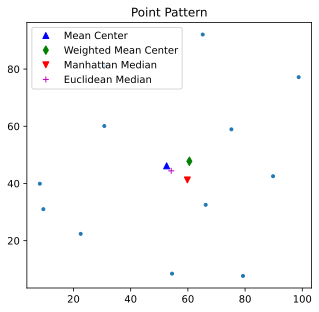

In [16]:
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

## 2. Dispersion and orientation

### Standard Distance & Standard Distance Circle

$$SD = \displaystyle \sqrt{\frac{\sum^n_{i=1}(x_i-x_{m})^2}{n} + \frac{\sum^n_{i=1}(y_i-y_{m})^2}{n}}$$

The Standard distance is  closely related to the usual definition of the standard deviation of a data set, and it provides a measure of how dispersed the events are around their mean center $(x_m,y_m)$.  Taken together, these measurements can be used to plot a summary circle (standard distance circle) for the point pattern, centered at $(x_m,y_m)$ with radius $SD$, as shown below.

In [17]:
stdd = std_distance(pp.points)
stdd

np.float64(40.14980648908671)

Plot mean center as well as the standard distance circle.

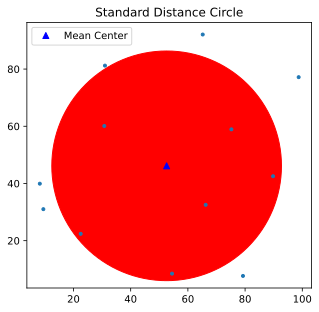

In [18]:
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r')
ax = pp.plot(get_ax=True, title='Standard Distance Circle')
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
ax.set_aspect('equal')
plt.legend(numpoints=1)

From the above figure, we can observe that there are five points outside the standard distance circle which are potential outliers.

## 3. Standard deviational ellipse

Compared with standard distance circle which measures dispersion using a single parameter $SD$, standard deviational ellipse measures dispersion and trend in two dimensions through angle of rotation $\theta$, dispersion along major axis $s_x$ and dispersion along minor axis $s_y$:

* Major axis defines the direction of maximum spread in the distribution. $s_x$ is the semi-major axis (half the length of the major axis):

$$ s_x = \displaystyle \sqrt{\frac{2(\sum_{i=1}^n (x_i-\bar{x})\cos(\theta) - \sum_{i=1}^n (y_i-\bar{y})\sin(\theta))^2}{n-2}}$$

* Minor axis defines the direction of minimum spread and is orthogonal to major axis. $s_y$ is the semi-minor axis (half the length of the minor axis):

$$ s_y = \displaystyle \sqrt{\frac{2(\sum_{i=1}^n (x_i-\bar{x})\sin(\theta) - \sum_{i=1}^n (y_i-\bar{y})\cos(\theta))^2}{n-2}}$$

* The ellipse is rotated clockwise through an angle $\theta$:

$$\theta = \displaystyle \arctan{\{ (\sum_i(x_i-\bar{x})^2-\sum_i(y_i-\bar{y})^2) + \frac{[(\sum_i(x_i-\bar{x})^2-\sum_i(y_i-\bar{y})^2)^2 + 4(\sum_i(x-\bar{x})(y_i-\bar{y}))^2]^\frac{1}{2}}{2\sum_i(x-\bar{x})(y_i-\bar{y})}\}}$$


In [19]:
sx, sy, theta = ellipse(pp.points)
sx, sy, theta

(np.float64(47.945446085971454),
 np.float64(39.62386788646298),
 np.float64(0.46686948392980593))

In [20]:
theta_degree = np.degrees(theta) #need degree of rotation to plot the ellipse
theta_degree

np.float64(26.749651012628693)

The Standard Deviational Ellipse for the point pattern is rotated clockwise by $63.25^{\circ}$.

<Figure size 614.4x460.8 with 0 Axes>

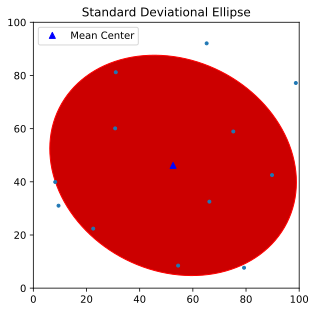

In [21]:
from matplotlib.patches import Ellipse
from pylab import figure, show,rand
fig = figure()
#ax = fig.add_subplot(111, aspect='equal')
e = Ellipse(xy=mean_center(pp.points), width=sx*2, height=sy*2, angle=-theta_degree) #angle is rotation in degrees (anti-clockwise)
ax = pp.plot(get_ax=True, title='Standard Deviational Ellipse')
ax.add_artist(e)
e.set_clip_box(ax.bbox)
e.set_facecolor([0.8,0,0])
e.set_edgecolor([1,0,0])
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_aspect('equal')
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend(numpoints=1)
show()

## 4. Shape analysis

### 4.1 Convex hull

[Convex hull](https://en.wikipedia.org/wiki/Convex_hull)

In [22]:
hull(pp.points)

array([[31.01, 81.21],
       [ 8.23, 39.93],
       [ 9.47, 31.02],
       [22.52, 22.39],
       [54.46,  8.48],
       [79.26,  7.68],
       [89.78, 42.53],
       [98.73, 77.17],
       [65.19, 92.08]])

By specifying "hull" argument **True** in PointPattern class method **plot**, we can easily plot convex hull of the point pattern.

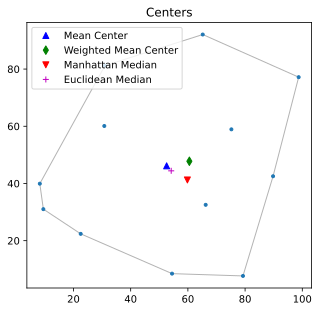

In [23]:
pp.plot(title='Centers', hull=True ) #plot point pattern "pp" as well as its convex hull
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

### 4.2 Minimum bounding rectangle

[Minimum bounding rectangle](https://en.wikipedia.org/wiki/Minimum_bounding_rectangle)

In [24]:
minimum_bounding_rectangle(pp.points)

(np.float64(8.23), np.float64(7.68), np.float64(98.73), np.float64(92.08))

Thus, four vertices of the  minimum bounding rectangle is $(8.23,7.68),(98.73,7.68),(98.73,92.08),(8.23,92.08)$.

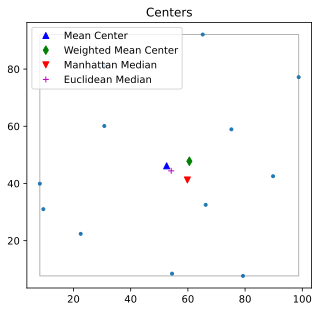

In [25]:
pp.plot(title='Centers', window=True ) #plot point pattern "pp" as well as its Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

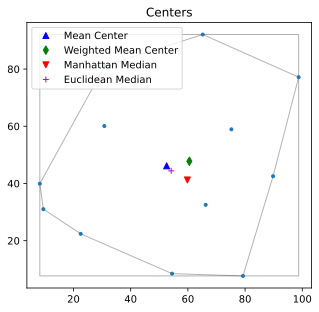

In [26]:
pp.plot(title='Centers',  hull=True , window=True )#plot point pattern "pp", convex hull, and Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

Plot Standard Distance Circle and Convex Hull.

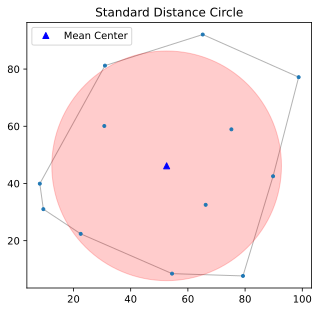

In [27]:
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r',alpha=0.2)
ax = pp.plot(get_ax=True, title='Standard Distance Circle', hull=True)
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
ax.set_aspect('equal')
plt.legend(numpoints=1)

## 5. Additional example: simulated patterns in Virginia

We apply the  centrography statistics and visualization to 2 simulated random datasets.

In [28]:
#from pysal.contrib import shapely_ext
from libpysal.cg import shapely_ext
from pointpats import PoissonPointProcess as csr
import libpysal as ps
from pointpats import as_window
#import pysal_examples

# open "vautm17n" polygon shapefile
va = ps.io.open(ps.examples.get_path("vautm17n.shp"))

# Create the exterior polygons for VA from the union of the county shapes
polys = [shp for shp in va]
state = shapely_ext.cascaded_union(polys)

### 5.1 Simulate a 100-point dataset within the Virginia state border under CSR (complete spatial randomness)

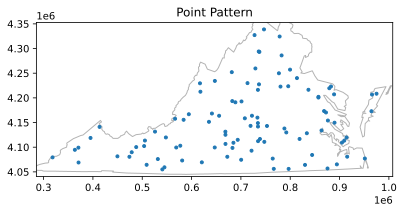

In [29]:
pp = csr(as_window(state), 100, 1, asPP=True).realizations[0]
pp.plot(window=True)

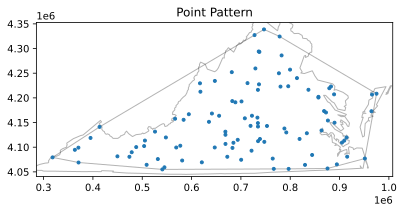

In [30]:
pp.plot(window=True, hull=True)

/home/runner/work/pointpats/pointpats/pointpats/centrography.py:505: UserWarning: Manhattan Median is not unique for even point patterns.
  return manhattan_median(points)


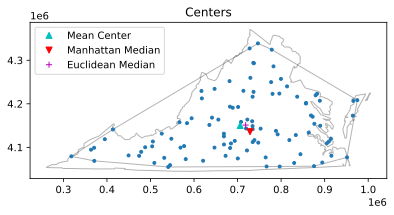

In [31]:
mc = mean_center(pp.points)
mm = manhattan_median(pp.points)
em = euclidean_median(pp.points)
pp.plot(title='Centers',  hull=True , window=True )#plot point pattern "pp", convex hull, and Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'c^', label='Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

### 5.2 Simulate a 500-point dataset within the Virginia state border under CSR (complete spatial randomness)

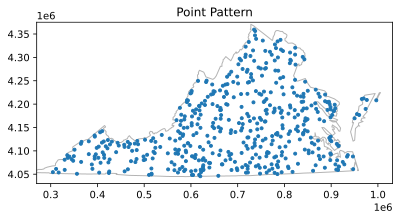

In [32]:
pp = csr(as_window(state), 500, 1, asPP=True).realizations[0]
pp.plot(window=True)

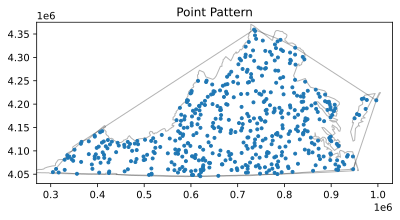

In [33]:
pp.plot(window=True, hull=True)

/home/runner/work/pointpats/pointpats/pointpats/centrography.py:505: UserWarning: Manhattan Median is not unique for even point patterns.
  return manhattan_median(points)


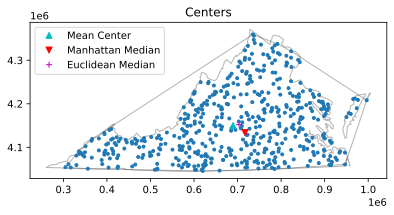

In [34]:
mc = mean_center(pp.points)
mm = manhattan_median(pp.points)
em = euclidean_median(pp.points)
pp.plot(title='Centers',  hull=True , window=True )#plot point pattern "pp", convex hull, and Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'c^', label='Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

If we calculate the Euclidean distances between every event point and Mean Center (Euclidean Median), and sum them up, we can see that Euclidean Median is the optimal point in iterms of minimizing the Euclidean distances to all the event points.

In [35]:
from pointpats import dtot

print(dtot(mc.tolist(), pp.points) > dtot(em.tolist(), pp.points))

True


## 6. Recap

In this notebook, we:

- Reviewed a range of **centrographic statistics** for planar point patterns,
  including measures of central tendency, dispersion, and shape.
- Used functions in `pointpats.centrography` to compute and visualize
  the mean center, weighted mean center, Manhattan and Euclidean medians.
- Explored measures of spread and orientation via the **standard distance**
  and **standard deviational ellipse**.
- Illustrated basic **shape descriptors**, such as the convex hull and
  minimum bounding rectangle, and examined how these relate to dispersion.
- Worked through an additional example based on simulated point patterns
  within the Virginia state border under CSR.

Together with the quadrat- and distance-based statistics notebooks, these
tools provide a complementary set of summaries for exploring spatial point
pattern structure in `pointpats`.
